# Create a model using DistilBERT tuned on only gear data

In [16]:
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertConfig, TFAutoModelWithLMHead, TFAutoModel, AutoModel

from sklearn.model_selection import train_test_split

import tensorflow as tf

import pandas as pd
import numpy as np

classifier = pipeline('sentiment-analysis')

In [17]:
import random
random.seed(42)

In [18]:
save_directory = "models/trailspace_model"

In [19]:
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
transformer_model = TFAutoModel.from_pretrained(save_directory, from_pt=True, config = config)

input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(50, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(3, activation='sigmoid')(X)
tf.keras.layers.Softmax(axis=-1)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False
    
model.compile(optimizer="Adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["acc"])

All PyTorch model weights were used when initializing TFDistilBertModel.

All the weights of TFDistilBertModel were initialized from the TF 2.0 model.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [20]:
df = pd.read_csv('data/labeled_forum_test.csv')
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["sentiment"], test_size=0.20, random_state=42)

In [21]:
# Create X values
tokenizer = AutoTokenizer.from_pretrained(save_directory)
X_train = tokenizer(
     list(X_train),
     padding=True,
     truncation=True,
     return_tensors="tf",
     max_length = 128
 )

X_test = tokenizer(
     list(X_test),
     padding=True,
     truncation=True,
     return_tensors="tf",
     max_length = 128
 )

In [22]:
# Create Y values
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [23]:
history = model.fit([X_train["input_ids"], X_train["attention_mask"]], 
          y_train, 
          batch_size=128, 
          epochs=30, 
          verbose=1, 
          validation_split=0.2)

Train on 2591 samples, validate on 648 samples
Epoch 1/30
2591/2591 [==============================] - 254s 98ms/sample - loss: 0.7702 - acc: 0.7337 - val_loss: 0.6992 - val_acc: 0.7500
Epoch 2/30
2591/2591 [==============================] - 226s 87ms/sample - loss: 0.6764 - acc: 0.7499 - val_loss: 0.6299 - val_acc: 0.7500
Epoch 3/30
2591/2591 [==============================] - 216s 83ms/sample - loss: 0.6153 - acc: 0.7607 - val_loss: 0.5810 - val_acc: 0.7778
Epoch 4/30
2591/2591 [==============================] - 164s 63ms/sample - loss: 0.5786 - acc: 0.7777 - val_loss: 0.5657 - val_acc: 0.7870
Epoch 5/30
2591/2591 [==============================] - 135s 52ms/sample - loss: 0.5634 - acc: 0.7785 - val_loss: 0.5473 - val_acc: 0.7917
Epoch 6/30
2591/2591 [==============================] - 135s 52ms/sample - loss: 0.5290 - acc: 0.7866 - val_loss: 0.5295 - val_acc: 0.8040
Epoch 7/30
2591/2591 [==============================] - 135s 52ms/sample - loss: 0.5266 - acc: 0.7981 - val_loss: 0.530

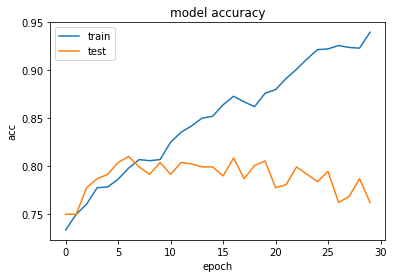

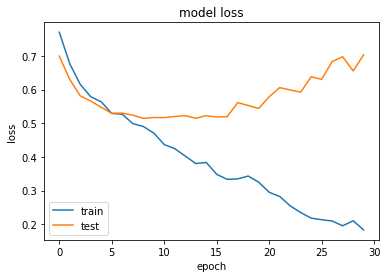

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='lower left')
plt.show()

In [26]:
score = model.evaluate([X_test["input_ids"], X_test["attention_mask"]], y_test, verbose=1)

810/810 [==============================] - 29s 35ms/sample - loss: 0.6669 - acc: 0.7704


In [27]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6669441355599297
Test Accuracy: 0.77037036


In [28]:
model.save_weights('models/final_models/gear_only/gear_only')

## best epoch is 7:
loss: 0.5266 - acc: 0.7981 - val_loss: 0.5300 - val_acc: 0.8102

I think this one became overfit...

In [31]:
history = model.fit([X_train["input_ids"], X_train["attention_mask"]], 
          y_train, 
          batch_size=128, 
          epochs=7, 
          verbose=1, 
          validation_split=0.2)

Train on 2591 samples, validate on 648 samples
Epoch 1/7
2591/2591 [==============================] - 142s 55ms/sample - loss: 0.1656 - acc: 0.9425 - val_loss: 0.7153 - val_acc: 0.7809
Epoch 2/7
2591/2591 [==============================] - 236s 91ms/sample - loss: 0.1581 - acc: 0.9402 - val_loss: 0.6779 - val_acc: 0.7855
Epoch 3/7
2591/2591 [==============================] - 236s 91ms/sample - loss: 0.1363 - acc: 0.9525 - val_loss: 0.7174 - val_acc: 0.8009
Epoch 4/7
2591/2591 [==============================] - 244s 94ms/sample - loss: 0.1390 - acc: 0.9521 - val_loss: 0.7303 - val_acc: 0.7855
Epoch 5/7
2591/2591 [==============================] - 246s 95ms/sample - loss: 0.1372 - acc: 0.9537 - val_loss: 0.7432 - val_acc: 0.7623
Epoch 6/7
2591/2591 [==============================] - 237s 92ms/sample - loss: 0.1216 - acc: 0.9595 - val_loss: 0.7148 - val_acc: 0.7963
Epoch 7/7
2591/2591 [==============================] - 241s 93ms/sample - loss: 0.1015 - acc: 0.9660 - val_loss: 0.7172 - val

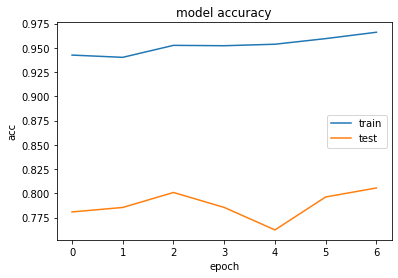

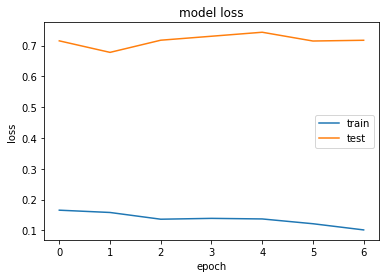

In [36]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='center right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='center right')
plt.show()

In [33]:
score = model.evaluate([X_test["input_ids"], X_test["attention_mask"]], y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

810/810 [==============================] - 55s 68ms/sample - loss: 0.7001 - acc: 0.7951
Test Score: 0.7001135146176374
Test Accuracy: 0.7950617


In [34]:
model.save_weights('models/final_models/gear_only2/gear_only2')